In [1]:
from rateslib import *

# Valuing Historical Swaps at Today's Date

A common operation is to want to value a swap which has an *effective* date **in the past**.
To do this, the swap should not be altered in its definition but it likely requires additional pricing information supplied,
in the form of **fixings**. See *'Cookbook > Working with Fixings'* for more detail on this aspect.

In [2]:
curve = Curve({dt(2024, 7, 3): 1.0, dt(2025, 7, 3): 0.95}, calendar="nyc")
irs = IRS(dt(2024, 6, 26), "1m", spec="usd_irs", curves=curve, fixed_rate=5.00)

This swap cant price directly because it is missing information on some of the fixings.

In [3]:
try: 
    irs.npv()
except ValueError as e:
    print(e)

RFRs could not be calculated, have you missed providing `fixings` or does the `Curve` begin after the start of a `FloatPeriod` including the `method_param` adjustment?
For further info see: Documentation > Cookbook > Working with fixings.


The SOFR fixings are needed for the following reference value dates in the past (as measured as of 3rd July 2024):

In [4]:
get_calendar("nyc").bus_date_range(dt(2024, 6, 26), dt(2024, 7, 2))

[datetime.datetime(2024, 6, 26, 0, 0),
 datetime.datetime(2024, 6, 27, 0, 0),
 datetime.datetime(2024, 6, 28, 0, 0),
 datetime.datetime(2024, 7, 1, 0, 0),
 datetime.datetime(2024, 7, 2, 0, 0)]

Normally these fixings would be populated by some automated data collection service or CSV file upload, but here they have been manually inserted.

In [5]:
from pandas import Series
sofr_fixings = Series(
    data=[5.34, 5.34, 5.33, 5.40, 5.35],
    index=get_calendar("nyc").bus_date_range(dt(2024, 6, 26), dt(2024, 7, 2))
)
sofr_fixings

2024-06-26    5.34
2024-06-27    5.34
2024-06-28    5.33
2024-07-01    5.40
2024-07-02    5.35
dtype: float64

The definition of the swap is altered to **also input the fixings** and then it is repriced with the curve, correctly, without raising errors.

In [6]:
irs = IRS(dt(2024, 6, 26), "1m", spec="usd_irs", curves=curve, fixed_rate=5.0, leg2_fixings=sofr_fixings)
irs.npv()

np.float64(113.51930516664925)

For further visibility on what rates are used to value the floating leg of the swap the **fixings_table** method can be used on the floating leg.

In [7]:
irs.leg2.fixings_table(curve)

,notional,dcf,rates
obs_dates,,,
2024-06-26,0.000000e+00,0.002778,5.340000
2024-06-27,0.000000e+00,0.002778,5.340000
2024-06-28,0.000000e+00,0.008333,5.330000
2024-07-01,0.000000e+00,0.002778,5.400000
2024-07-02,0.000000e+00,0.002778,5.350000
2024-07-03,1.000477e+06,0.005556,5.059776
2024-07-05,1.000759e+06,0.008333,5.060131
2024-07-08,1.001181e+06,0.002778,5.059420
2024-07-09,1.001321e+06,0.002778,5.059420


Alternatively the **cashflows** method gives an alternative, holistic perspective.

In [8]:
irs.cashflows()

,,Type,Period,Ccy,Acc Start,Acc End,Payment,Convention,DCF,Notional,DF,Collateral,Rate,Spread,Cashflow,NPV,FX Rate,NPV Ccy
leg1,0,FixedPeriod,Stub,USD,2024-06-26,2024-07-26,2024-07-30,act360,0.083333,1000000.0,0.996213,None,5.000000,NaN,-4166.666667,-4150.887045,1.0,-4150.887045
leg2,0,FloatPeriod,Stub,USD,2024-06-26,2024-07-26,2024-07-30,act360,0.083333,-1000000.0,0.996213,None,5.136741,0.0,4280.617516,4264.406350,1.0,4264.406350


# Valuing Spot Swaps at Future Dates

The current design of *rateslib* targets accurate evaluation of instruments at today's date.
Valuing swaps as of future dates is something that might be required in calculations such as those for XVA or scenario analysis.

Currently *rateslib* does have some limited features to permit this.

As an example suppose today's date is 3rd July 2024 and we construct a 1Y IRS with a monthly frequency. A more granular *Curve* is constructed in this example.

In [9]:
curve = Curve(
    nodes={
        dt(2024, 7, 3): 1.0,
        dt(2024, 8, 3): 1.0,
        dt(2024, 9, 3): 1.0,
        dt(2024, 10, 3): 1.0,
        dt(2024, 11, 3): 1.0,
        dt(2024, 12, 3): 1.0,
        dt(2025, 1, 3): 1.0,
        dt(2025, 2, 3): 1.0,
        dt(2025, 3, 3): 1.0,
        dt(2025, 4, 3): 1.0,
        dt(2025, 5, 3): 1.0,
        dt(2025, 6, 3): 1.0,
        dt(2025, 7, 3): 1.0,
    },
    calendar="nyc",
)
solver = Solver(
    curves=[curve],
    instruments=[
        IRS(dt(2024, 7, 3), _, spec="usd_irs", curves=curve) for _ in
        ["1m", "2m", "3m", "4m", "5m", "6m", "7m", "8m", "9m", "10m", "11m", "1y"]
    ],
    s=[5.33, 5.33, 5.315, 5.28, 5.25, 5.21, 5.17, 5.15, 5.11, 5.07, 5.04, 5.00]
)

SUCCESS: `func_tol` reached after 3 iterations (levenberg_marquardt), `f_val`: 2.4782111521459966e-12, `time`: 0.0070s


In [10]:
irs = IRS(dt(2024, 7, 3), "11m", "M", spec="usd_irs", curves=curve, fixed_rate=5.04)
irs.npv()

<Dual: -1065.843488, (b10c9_0, b10c9_1, b10c9_2, ...), [999706.0, -4301.1, -4596.4, ...]>

### Today's date as the valuation evaluation date
Today's date, as the evaluation date, is derived from the initial node date of the **discount curve**, i.e. the date at which the discount factor is necessarily set to be equal to 1.0.

The initial node date can be **translated** on a *Curve* to a date in the future as follows.

In [11]:
translated_curve = curve.translate(dt(2024, 10, 15))

If the swap is then attempted to be priced with this translated *Curve* it will fail for the same reason as the section above - it cannot forecast rates before it starts.

In [12]:
try: 
    irs.npv(curves=translated_curve)
except ValueError as e:
    print(e)

RFRs could not be calculated, have you missed providing `fixings` or does the `Curve` begin after the start of a `FloatPeriod` including the `method_param` adjustment?
For further info see: Documentation > Cookbook > Working with fixings.


However, in this case the fixings are not known becuase 15th August 2024 is a future date.
The solution is to supply a separate **forecast curve** and **discount curve**, where the forecast curve is capable of calculating the relevant rates.
In this case the forecast curve is the very same curve that is created as of today's date.


In [13]:
irs.npv(curves=[curve, translated_curve])

<Dual: -1830.917069, (b10c9_0, b10c9_1, b10c9_2, ...), [0.0, 0.0, 0.0, ...]>

When the cashflows are analysed, one can visually inspect that any cashflow that is paid before the initial node date of the discount curve is set to zero value. The floating rates are demonstarted here showing that the floating rates have still been correctly forecast for each *FloatPeriod*.

In [14]:
irs.cashflows(curves=[curve, translated_curve])[12:16]

Type   Period  Ccy  Acc Start    Acc End    Payment Convention  \
leg2 0  FloatPeriod  Regular  USD 2024-07-03 2024-08-05 2024-08-07     act360   
     1  FloatPeriod  Regular  USD 2024-08-05 2024-09-03 2024-09-05     act360   
     2  FloatPeriod  Regular  USD 2024-09-03 2024-10-03 2024-10-07     act360   
     3  FloatPeriod  Regular  USD 2024-10-03 2024-11-04 2024-11-06     act360   

             DCF   Notional        DF Collateral      Rate  Spread  \
leg2 0  0.091667 -1000000.0  0.000000       None  5.330000     0.0   
     1  0.080556 -1000000.0  0.000000       None  5.304085     0.0   
     2  0.083333 -1000000.0  0.000000       None  5.235937     0.0   
     3  0.088889 -1000000.0  0.996894       None  5.109967     0.0   

           Cashflow         NPV  FX Rate     NPV Ccy  
leg2 0  4885.833333     0.00000      1.0     0.00000  
     1  4272.735240     0.00000      1.0     0.00000  
     2  4363.280847     0.00000      1.0     0.00000  
     3  4542.193325  4528.08681      1.0  4528.08681

### Plotting Future Value

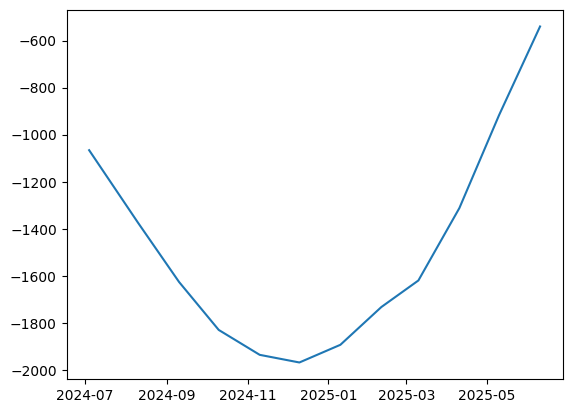

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)

def _npv(date):
    t_curve = curve.translate(date)
    return irs.npv(curves=[curve, t_curve])
    
dates=[
    dt(2024, 7, 4),
    dt(2024, 8, 10),
    dt(2024, 9, 10),
    dt(2024, 10, 10),
    dt(2024, 11, 10),
    dt(2024, 12, 10),
    dt(2025, 1, 10),
    dt(2025, 2, 10),
    dt(2025, 3, 10),
    dt(2025, 4, 10),
    dt(2025, 5, 10),
    dt(2025, 6, 10),
]

ax.plot(dates, [_npv(_) for _ in dates])

The general structure of this plot is as described in the section on *'Cash, Collateral and Credit'* in **Pricing and Trading Interest Rate Derivatives**.